In [1]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

import seaborn as sns
sns.set_style('whitegrid')

import torch
import torch.nn as nn

from ta.volume import VolumeWeightedAveragePrice
from ta.momentum import ROCIndicator
from ta.momentum import RSIIndicator
from ta.momentum import StochRSIIndicator

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# project modules
import importlib
import model
from data_processing import create_loaders
from data_processing import normalize_data
from data_processing import split_to_sequences
from training import train_model
from training import predict
from visualization import plot_losses
from visualization import draw_prediction
from positional import PositionalEncoding
from positional import Time2Vector
from data_generator import generate_df

# importlib.reload(pos)
%load_ext autoreload
%autoreload 2

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


## Machine Learning Capstone
PAST DUE

2 of 3 concepts completed

In this capstone project, you will leverage what you’ve learned throughout the Nanodegree program to solve a problem of your choice by applying machine learning algorithms and techniques.
You will first define the problem you want to solve and investigate potential solutions and performance metrics.

### Analisys and visualization.
Next, you will analyze the problem through visualizations and data exploration to have a better understanding of what algorithms and features are appropriate for solving it.

### TODO
1. You will then implement your algorithms and metrics of choice, documenting the preprocessing, refinement, and postprocessing steps along the way.
2. Afterward, you will collect results about the performance of the models used, visualize significant quantities, and validate/justify these values.
3. Finally, you will construct conclusions about your results, and discuss whether your implementation adequately solves the problem.

Think about a technical field or domain that you are passionate about, such as robotics, virtual reality, finance, natural language processing, or even artificial intelligence (the possibilities are endless!). Then, choose an existing problem within that domain that you are interested in which you could solve by applying machine learning algorithms and techniques. Be sure that you have collected all of the resources needed (such as data sets) to complete this project, and make the appropriate citations wherever necessary in your report.

In addition, you may find a technical domain (along with the problem and dataset) as competitions on platforms such as Kaggle, or Devpost. This can be helpful for discovering a particular problem you may be interested in solving as an alternative to the suggested problem areas above. In many cases, some of the requirements for the capstone project are already defined for you when choosing from these platforms.

For whichever application area or problem you ultimately investigate, there are five major stages to this capstone project which you will move through and subsequently document. Each stage plays a significant role in the development life cycle of beginning with a problem definition and finishing with a polished, working solution. As you make your way through developing your project, be sure that you are also working on a rough draft of your project report, as it is the most important aspect to your submission!

### Evaluation
Your project will be reviewed by a Udacity reviewer against the Machine Learning Capstone project rubric. Be sure to review this rubric thoroughly and self-evaluate your project before submission. All criteria found in the rubric must be meeting specifications for you to pass.

### Submission Files
At a minimum, your submission will be required to have the following files listed below. If your submission method of choice is uploading an archive (*.zip), please take into consideration the total file size. You will need to include

Your capstone proposal document as proposal.pdf if you have completed the pre-requisite Capstone Proposal project. Please also include your review link in the student submission notes.
A project report (in PDF format only) addressing the five major project development stages. The recommended page length for a project report is approximately nine to fifteen pages. Please do not export an iPython Notebook as PDF for your project report.
All development Python code used for your project that is required to reproduce your implemented solution and result. Your code should be in a neat and well-documented format. Using iPython Notebooks is strongly encouraged for development.
A README documentation file which briefly describes the software and libraries used in your project, including any necessary references to supporting material. If your project requires setup/startup, ensure that your README includes the necessary instructions.
Any additional supporting material such as datasets, images, or input files that are necessary for your project's development and implementation. If these files are too large and you are uploading your submission, instead provide appropriate means of acquiring the necessary files in your included README.
I'm Ready!
When you're ready to submit your project, click on the Submit Project button at the bottom of this page.

If you are having any problems submitting your project or wish to check on the status of your submission, please email us at **machine-support@udacity.com** or visit us in the discussion forums.

What's Next?
You will get an email as soon as your reviewer has feedback for you. In the meantime, review your next project and feel free to get started on it or the courses supporting it!

In [3]:
# Load data
stock_list = ['NFLX', 'EPAM', 'AAPL']

end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

for stock in stock_list:
    globals()[stock] = yf.download(stock, start, end)

stock_data = [NFLX, EPAM, AAPL]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# generate test dataset
generated_df = generate_df()
generated_df["Adj Close"] = generated_df["views"]
data_len = len(generated_df)
print(f"Dataset size: {data_len}")
print(generated_df.head())

Dataset size: 731
   timestamp  index  amplitude    offset     views  Adj Close
0 2018-01-01      0  -0.767742 -0.111677 -0.271415  -0.271415
1 2018-01-02      1  -0.769072 -0.112087 -0.325620  -0.325620
2 2018-01-03      2  -0.770401 -0.112326 -0.430652  -0.430652
3 2018-01-04      3  -0.771731 -0.112384 -0.374434  -0.374434
4 2018-01-05      4  -0.773061 -0.112259 -0.339406  -0.339406


<AxesSubplot:xlabel='timestamp'>

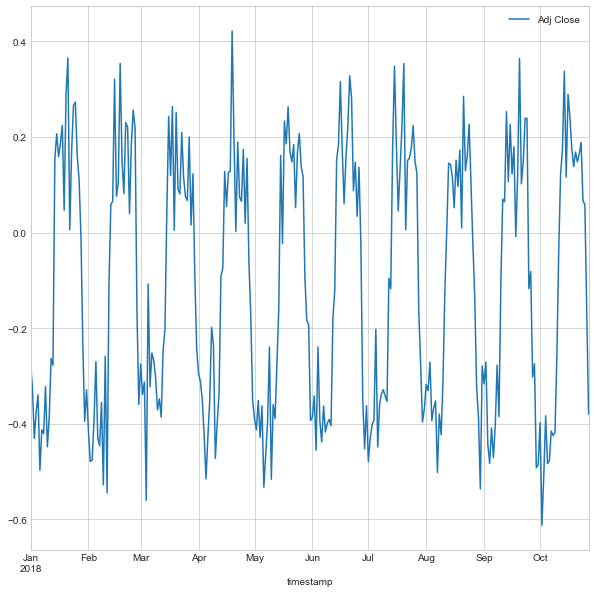

In [5]:
generated_df[:300].plot(x="timestamp", y="Adj Close",
        kind="line", figsize=(10, 10))

In [7]:
data = EPAM
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-09-25,84.000000,84.269997,82.750000,84.139999,84.139999,277800
2017-09-26,84.650002,84.720001,83.919998,84.540001,84.540001,181100
2017-09-27,85.000000,86.209999,84.690002,85.440002,85.440002,304600
2017-09-28,85.000000,85.500000,84.629997,85.400002,85.400002,261300
2017-09-29,85.050003,88.180000,84.980003,87.930000,87.930000,610700


In [15]:
def plot_stocks_data(columns, title = "", x_label = None, y_label = None):
    fig = plt.figure(figsize=(15, 6))
    for i, stock in enumerate(stock_data, 1):
        ax = fig.add_subplot(2, 2, i)
        stock[columns].plot(ax=ax)
        plt.ylabel(y_label)
        plt.xlabel(x_label)
        plt.title(f"{title} {stock_list[i - 1]}")
    
    fig.tight_layout()

In [11]:
def plot_stock_data(stock, collumns, title = "", x_label = None, y_label = None):
    fig = plt.figure(figsize=(15, 6))
    stock[collumns].plot()
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    
    fig.tight_layout()

In [9]:
def plot_stock_data_distribution(column, title = "", x_label = None, y_label = None):
    fig = plt.figure(figsize=(15, 6))
    for i, stock in enumerate(stock_data, 1):
        ax = fig.add_subplot(2, 2, i)
        stock[column].hist(bins=50)
        plt.ylabel(y_label)
        plt.xlabel(x_label)
        plt.title(f"{title} {stock_list[i - 1]}")
    plt.tight_layout()

<Figure size 1080x432 with 0 Axes>

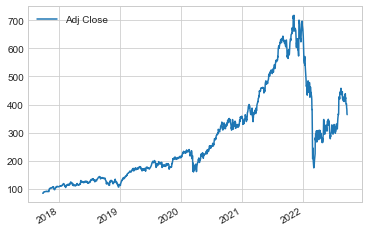

In [13]:
plot_stock_data(EPAM, ["Adj Close"])

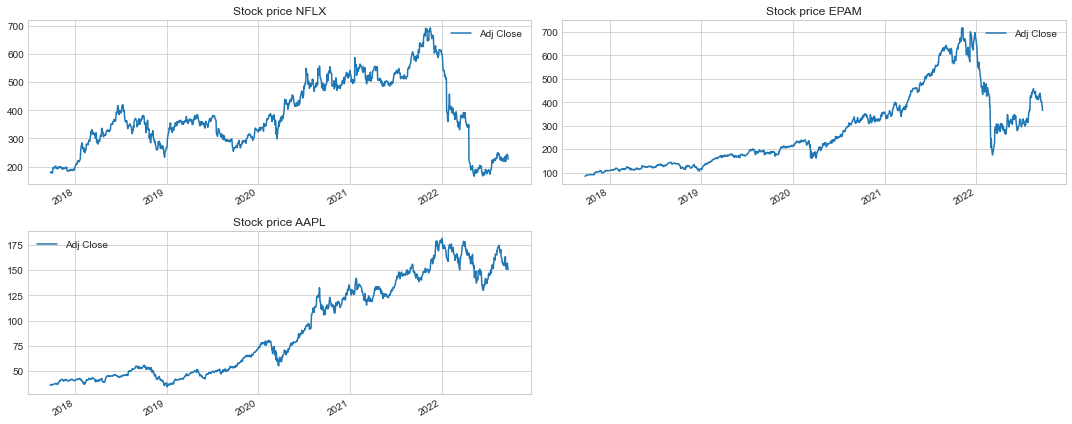

In [16]:
# Plot stock market prices
plot_stocks_data(["Adj Close"], "Stock price")

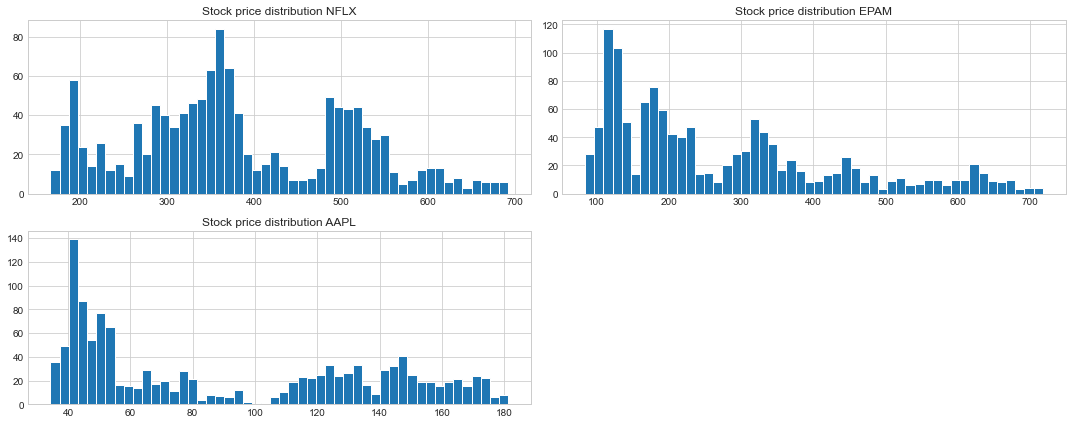

In [18]:
# Plot stock market price distibution
plot_stock_data_distribution("Adj Close", "Stock price distribution")

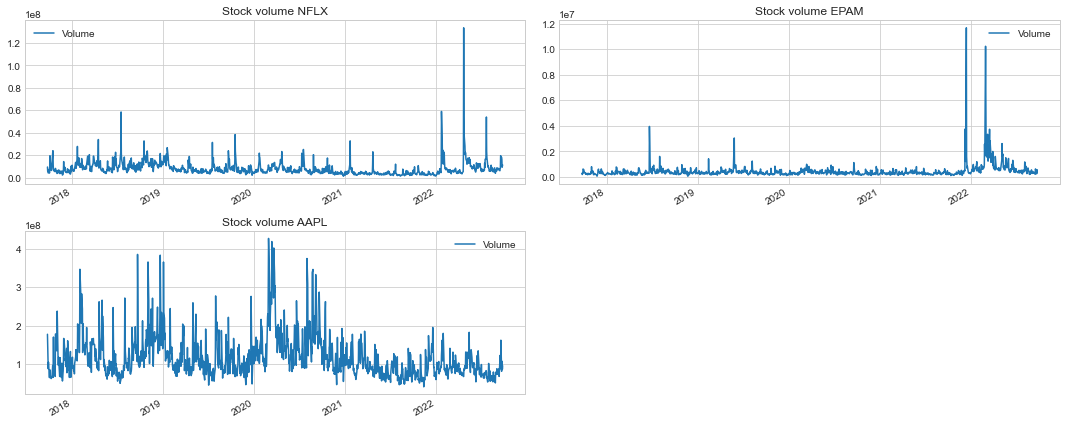

In [19]:
# Plot stock market volume
plot_stocks_data(["Volume"], "Stock volume")

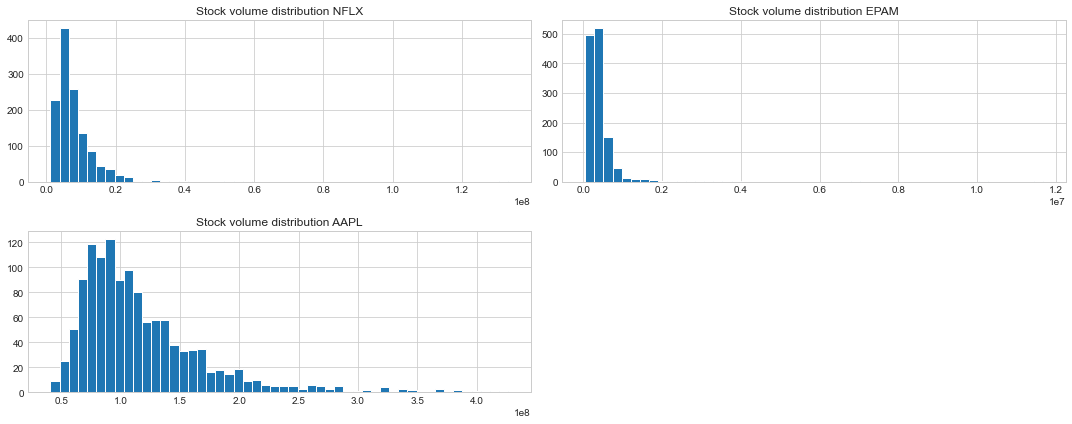

In [21]:
# Plot stock market volume distibution
plot_stock_data_distribution("Volume", "Stock volume distribution")

In [13]:
for i, stock in enumerate(stock_data, 1):
    std = stock["Volume"].std()
    name = stock_list[i-1]
    print(f"{name} stock volume std: {std}")

NFLX stock volume std: 7257334.48613846
EPAM stock volume std: 719521.5717025134
AAPL stock volume std: 56086954.509429105


## Feature engenering

**TODO**: add description for about feature engenering, why do we need them and which one is better to have, attach articles links if needed.

### Exponential smoothing

In [14]:
# Exponential smoothing
alphas = [0.1, 0.3, 0.5, 0.9]

for alpha in alphas:
    for stock in stock_data:
        column_name = f"EWM_{alpha}"
        stock[column_name] = stock['Adj Close'].ewm(alpha=alpha, adjust=False).mean()

for stock in stock_data:
    column_name = f"EWM"
    stock[column_name] = stock['Adj Close'].ewm(span=9, adjust=False).mean()

<Figure size 1080x432 with 0 Axes>

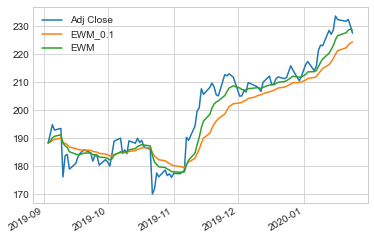

In [15]:
plot_stock_data(EPAM[:100], ['Adj Close', 'EWM_0.1', 'EWM'])

### Volume Weighted Average Price (VWAP)

In [22]:
for stock in stock_data:
    vwap = VolumeWeightedAveragePrice(
        high=stock['High'],
        low=stock['Low'],
        close=stock['Adj Close'],
        volume=stock['Volume'],
        window=9)
    stock['VWAP'] = vwap.volume_weighted_average_price()

<Figure size 1080x432 with 0 Axes>

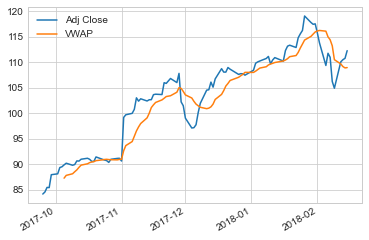

In [25]:
plot_stock_data(EPAM[:100], ['Adj Close', 'VWAP'])

### Momentum

In [18]:
for stock in stock_data:
    indicator_roc = ROCIndicator(close=stock['Adj Close'])
    indicator_rci = RSIIndicator(close=stock['Adj Close'])
    indicator_srci = StochRSIIndicator(close=stock['Adj Close'])
    stock['ROC'] = indicator_roc.roc()
    stock['RSI'] = indicator_rci.rsi()
    stock['SRSI'] = indicator_srci.stochrsi()

<Figure size 1080x432 with 0 Axes>

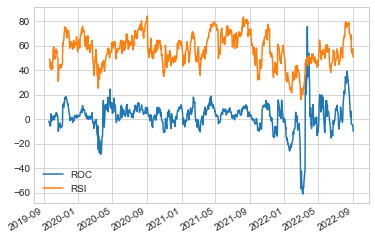

In [19]:
plot_stock_data(EPAM, ['ROC', 'RSI'])

<Figure size 1080x432 with 0 Axes>

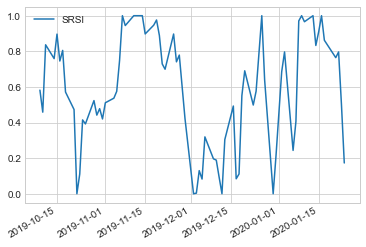

In [20]:
plot_stock_data(EPAM[:100], ['SRSI'])

### Return

In [21]:
for stock in stock_data:
    stock['Return'] = stock['Adj Close'].pct_change()
    stock['Return Log'] = np.log(1 + stock['Return'])

<Figure size 1080x432 with 0 Axes>

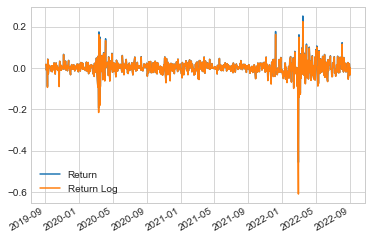

In [22]:
plot_stock_data(EPAM, ['Return', 'Return Log'])

### Return Normalization

In [23]:
# limit return
upper_bound = 0.25
lower_bound = -upper_bound  
def return_normalization(x):
    x = x if x < upper_bound else upper_bound
    x = x if x > lower_bound else lower_bound
    
    # scale value to range from -0.5 to 0.5
    x = x * 2
    return round(x + 0.5, 2)

for stock in stock_data:
    stock['Return Norm'] = stock['Return'].apply(return_normalization)

### Volume normalization

In [24]:
def scale_data(values, scaler):
    data = values.to_numpy().reshape(-1, 1)
    scaler.fit(data)
    data = scaler.transform(data)
    return data.reshape(1, -1)[0]

df = pd.DataFrame(data={
    "a": [1, 2, 3, 4, 5, 6, 7, 8, 9]
})
scaler = MinMaxScaler()
print(scale_data(df["a"], scaler))

[0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]


### Feature correlation

<AxesSubplot:>

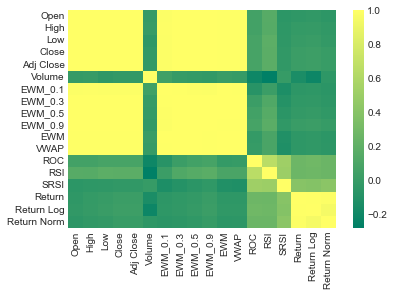

In [25]:
sns.heatmap(EPAM.corr(), cmap='summer')

In [26]:
print(data.shape)
data.dropna(how='any', axis=0, inplace=True)
print(data.shape)
print(data.head)

(758, 18)
(732, 18)
<bound method NDFrame.head of                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-10-09  186.110001  186.759995  184.210007  185.830002  185.830002   
2019-10-10  185.289993  186.800003  184.059998  184.440002  184.440002   
2019-10-11  186.229996  190.860001  186.000000  189.020004  189.020004   
2019-10-14  188.979996  188.979996  186.360001  188.199997  188.199997   
2019-10-15  188.630005  190.740005  188.449997  189.949997  189.949997   
...                ...         ...         ...         ...         ...   
2022-08-29  409.429993  421.730011  408.399994  416.000000  416.000000   
2022-08-30  422.640015  425.709991  409.690002  424.709991  424.709991   
2022-08-31  427.709991  432.609985  422.500000  426.500000  426.500000   
2022-09-01  421.000000  422.179993  402.510010  412.209991  412.209991   
2022-09-02  418.869995  424.890015  408.114990  412.140015  41

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 732 entries, 2019-10-09 to 2022-09-02
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         732 non-null    float64
 1   High         732 non-null    float64
 2   Low          732 non-null    float64
 3   Close        732 non-null    float64
 4   Adj Close    732 non-null    float64
 5   Volume       732 non-null    int64  
 6   EWM_0.1      732 non-null    float64
 7   EWM_0.3      732 non-null    float64
 8   EWM_0.5      732 non-null    float64
 9   EWM_0.9      732 non-null    float64
 10  EWM          732 non-null    float64
 11  VWAP         732 non-null    float64
 12  ROC          732 non-null    float64
 13  RSI          732 non-null    float64
 14  SRSI         732 non-null    float64
 15  Return       732 non-null    float64
 16  Return Log   732 non-null    float64
 17  Return Norm  732 non-null    float64
dtypes: float64(17), int64(1)
memory

In [28]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume,EWM_0.1,EWM_0.3,EWM_0.5,EWM_0.9,EWM,VWAP,ROC,RSI,SRSI,Return,Return Log,Return Norm
count,732.000000,732.000000,732.000000,732.000000,732.000000,7.320000e+02,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000
mean,369.073306,375.450983,362.558832,369.048512,369.048512,4.802199e+05,366.159454,368.301997,368.735289,369.014018,367.746305,367.435956,2.306026,56.524587,0.543893,0.001891,0.001098,0.504481
std,145.469152,146.615539,143.621539,144.992496,144.992496,7.311815e+05,143.136234,144.462268,144.729734,144.948324,144.128686,145.299132,12.583197,12.870699,0.346908,0.038309,0.040886,0.071167
min,163.210007,168.630005,151.970001,160.130005,160.130005,9.700000e+04,179.538323,171.824624,168.380347,162.666042,175.247215,171.156937,-61.189192,15.942280,0.000000,-0.456763,-0.610210,0.000000
25%,241.395000,246.662502,234.640003,239.950001,239.950001,2.338250e+05,243.088285,241.733416,240.033069,239.607365,242.152669,238.168107,-2.204233,48.590262,0.235542,-0.013370,-0.013460,0.470000
50%,330.074997,335.779999,324.585007,329.559998,329.559998,3.262000e+05,327.431034,327.091284,328.457480,329.558394,326.819214,326.329907,3.130060,56.918507,0.576128,0.001913,0.001911,0.500000
75%,459.382492,463.707504,453.535011,459.144997,459.144997,4.963250e+05,464.601622,458.854358,458.814727,459.074887,459.691933,457.407365,8.160284,66.105539,0.875574,0.017527,0.017375,0.532500
max,725.400024,725.400024,711.650024,717.489990,717.489990,1.166500e+07,668.856798,703.708594,712.961183,717.004214,692.738118,689.204143,75.429055,84.080663,1.000000,0.251866,0.224636,1.000000


## Data split

Validation and forecase horizon will be a month, there are 21 traiding day in month in average. All the other days data will be used for model training.

**TODO:** add image explaining intervals. Example: https://miro.medium.com/max/1400/1*B0Ll7tyk-BYvU7k403aakA.png

In [29]:
valid_len = 105 # in days
test_len = 105 # in days
train_len = 7 # in days

**TODO:** add description about day splitting from this article https://www.rasgoml.com/feature-engineering-tutorials/scikit-learn-time-series-split

In [30]:
min_date = data.index.min()
max_date = data.index.max()
valid_start_date = data.index[-valid_len-test_len]
test_start_date = data.index[-test_len]

In [31]:
df = pd.DataFrame(data={
    "a": [1, 2, 3, 4, 5, 6, 7, 8, 9],
    "b": [10, 20, 30, 40, 50, 60, 70, 80, 90],
    "c": [100, 200, 300, 400, 500, 600, 700, 800, 900]
})
scalers = [
    (["a"], MinMaxScaler()),
    (["b", "c"], MinMaxScaler())
]
features_df = normalize_data(df, scalers, True)
print(features_df.head())

Transform columns ['a']
Transform columns ['b', 'c']
       a         b         c
0  0.000  0.000000  0.101124
1  0.125  0.011236  0.213483
2  0.250  0.022472  0.325843
3  0.375  0.033708  0.438202
4  0.500  0.044944  0.550562


In [32]:
df = pd.DataFrame(data={
    "a": [1, 2, 3, 4, 5, 6, 7, 8, 9],
    "b": [10, 20, 30, 40, 50, 60, 70, 80, 90]
})
X, y = split_to_sequences(df, 3, 1, "b")
print(f"X: {X[0]}")
print(f"y: {y[0]}")

X: [[ 1 10]
 [ 2 20]
 [ 3 30]]
y: [40]


## Positional encoding

**TODO**: add description for positional and time2vector encoders, attach articles links if needed.

In [33]:
# Positinal encoder parameters
batch = 10
seq_len = 5
feature_num = 4

# Positinal encoder input
input = torch.randn(batch, seq_len, feature_num)
print(f"Input: {input.shape}")

Input: torch.Size([10, 5, 4])


In [34]:
# Positional encoder test
posEncoder = PositionalEncoding(feature_num, seq_len, True)
output = posEncoder(input)
print(f"Output: {output.shape}")

Output: torch.Size([10, 5, 4])


In [35]:
# Time to vector encoder test
time2vecEncoder = Time2Vector(feature_num, seq_len)
output = time2vecEncoder(input)
print(f"Output: {output.shape}")

Output: torch.Size([10, 5, 8])


## Data normalization

In [36]:
# Robust scaler
robustScalerData = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10]]

robustScaler = RobustScaler()
robustScaler.fit(robustScalerData)
print(robustScaler.transform(robustScalerData))

[[-1. ]
 [-0.8]
 [-0.6]
 [-0.4]
 [-0.2]
 [ 0. ]
 [ 0.2]
 [ 0.4]
 [ 0.6]
 [ 0.8]
 [ 1. ]]


In [37]:
# Min max scaler
minMaxData = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10]]

minMaxScaler = MinMaxScaler()
minMaxScaler.fit(minMaxData)
print(minMaxScaler.scale_)
print(minMaxScaler.transform(minMaxData))

[0.1]
[[0. ]
 [0.1]
 [0.2]
 [0.3]
 [0.4]
 [0.5]
 [0.6]
 [0.7]
 [0.8]
 [0.9]
 [1. ]]


In [38]:
# Standard scaler
standardData = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10]]

standardScaler = StandardScaler()
standardScaler.fit(standardData)
print(standardScaler.mean_)
print(standardScaler.transform(standardData))

[5.]
[[-1.58113883]
 [-1.26491106]
 [-0.9486833 ]
 [-0.63245553]
 [-0.31622777]
 [ 0.        ]
 [ 0.31622777]
 [ 0.63245553]
 [ 0.9486833 ]
 [ 1.26491106]
 [ 1.58113883]]


### Convolution

In [39]:
input = torch.randn(32, 7, 1)

conv = nn.Conv1d(7, 32, 2)
pool = nn.MaxPool1d(2)
output = conv(input)
print(output.shape)
output = pool(output)
print(output.shape)

RuntimeError: Calculated padded input size per channel: (1). Kernel size: (2). Kernel size can't be greater than actual input size

## Training

**TODO:** take concept about training and validation from the article
https://towardsdatascience.com/forecasting-stock-prices-using-exponential-smoothing-b37dfe54e8e9

In [40]:
# Data columns
print(data.columns)
# target_column = "Adj Close"
# feature_columns = ["Adj Close", "Volume"]
target_column = "Adj Close"
feature_columns = ["Adj Close"]

# Scalers
scalers = [
    (["Adj Close"], MinMaxScaler()),
    # (["Volume"], MinMaxScaler()),
]

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'EWM_0.1',
       'EWM_0.3', 'EWM_0.5', 'EWM_0.9', 'EWM', 'VWAP', 'ROC', 'RSI', 'SRSI',
       'Return', 'Return Log', 'Return Norm'],
      dtype='object')


In [41]:
# Create loaders
train_loader, valid_loader, test_loader = create_loaders(data[feature_columns], target_column, scalers, valid_len, test_len)

Train data shape: (522, 1)
Valid data shape: (105, 1)
Test data shape: (105, 1)
Transform columns ['Adj Close']
Transform columns ['Adj Close']
Transform columns ['Adj Close']


Epoch 1
Train loss: 2.742323
Test loss: 0.122319
Epoch 2


/Users/nin/opt/anaconda3/envs/udacity/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/nin/opt/anaconda3/envs/udacity/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train loss: 2.800770
Test loss: 0.105134
Epoch 3
Train loss: 2.618381
Test loss: 0.085060
Epoch 4
Train loss: 2.815945
Test loss: 0.075217
Epoch 5
Train loss: 2.586323
Test loss: 0.087153
Epoch 6
Train loss: 2.462262
Test loss: 0.073286
Epoch 7
Train loss: 2.532367
Test loss: 0.175619
Epoch 8
Train loss: 2.479585
Test loss: 0.066327
Epoch 9
Train loss: 2.504316
Test loss: 0.076954
Epoch 10
Train loss: 2.443308
Test loss: 0.092375
Epoch 11
Train loss: 2.307276
Test loss: 0.066262
Epoch 12
Train loss: 2.294535
Test loss: 0.067180
Epoch 13
Train loss: 2.277529
Test loss: 0.082469
Epoch 14
Train loss: 2.147764
Test loss: 0.070094
Epoch 15
Train loss: 2.141123
Test loss: 0.064467
Epoch 16
Train loss: 2.318117
Test loss: 0.073521
Epoch 17
Train loss: 2.173080
Test loss: 0.063233
Epoch 18
Train loss: 2.092794
Test loss: 0.065459
Epoch 19
Train loss: 2.060531
Test loss: 0.062869
Epoch 20
Train loss: 2.014061
Test loss: 0.069359
Epoch 21
Train loss: 2.227095
Test loss: 0.065156
Epoch 22
Train l

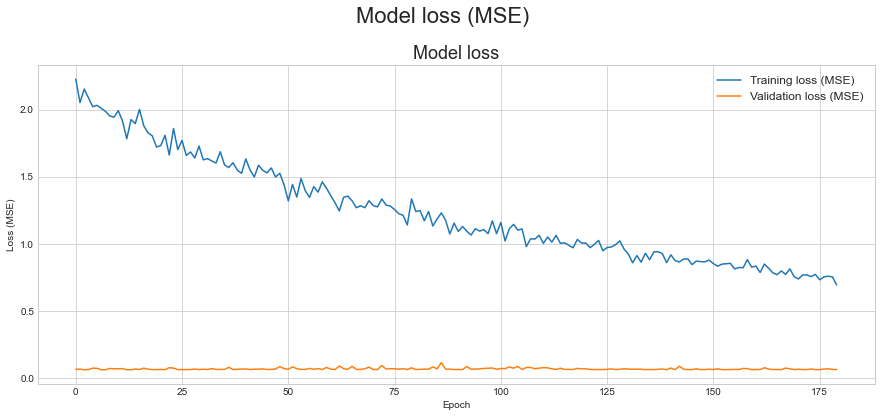

In [1119]:
from model import Transformer

epochs=200
lr=0.000001

model = Transformer(feature_size=len(feature_columns), use_mask=False)
train_losses, valid_losses = train_model(model, train_loader, valid_loader, epochs, lr)
plot_losses(train_losses[20:], valid_losses[20:])

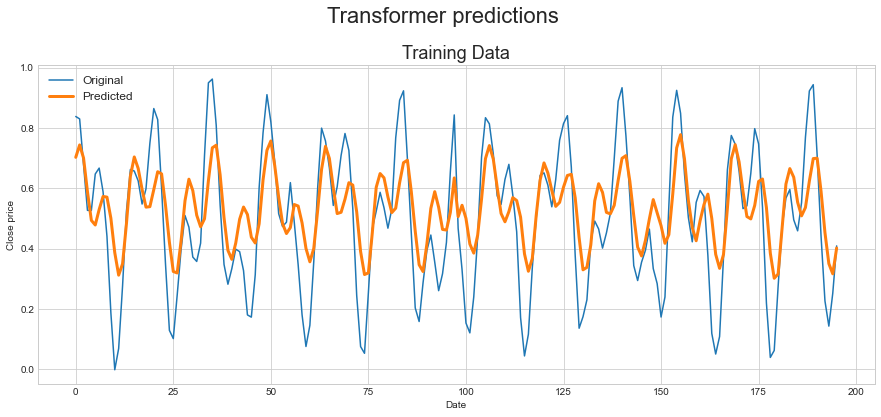

In [1120]:
original, predictions = predict(model, [valid_loader, test_loader])
draw_prediction(original, predictions)

## Training positional encoding

In [1158]:
# Data columns
print(f"Seq length: {train_len}")
print(data.columns)
# target_column = "Adj Close"
# feature_columns = ["Adj Close"]

target_column = "Adj Close"
feature_columns = ["Adj Close", "Volume"]

# target_column = "Return"
# feature_columns = ["Return", "Volume"]

# feature_columns = ["Return", "SRSI"]
# target_column = "Return"

# target_column = "Return Norm"
# feature_columns = ["Return Norm", "Volume"]

# target_column = "Return Norm"
# feature_columns = ["Return Norm", "Volume"]

# target_column = "Adj Close"
# feature_columns = ["Adj Close", "Volume Norm"]

# target_column = "Return Norm"
# feature_columns = ["Return Norm", "Volume Norm"]

# Scalers
scalers = [
    # (["Return"], MinMaxScaler()),
    (["Adj Close"], MinMaxScaler()),
    (["Volume"], MinMaxScaler()),
    # (["Volume Norm"], MinMaxScaler()),
    # (["VWAP"], MinMaxScaler()),
    # (["Return Norm"], None),
    # (["SRSI"], None),
]

Seq length: 7
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [1159]:
# Create loaders
train_loader, valid_loader, test_loader = create_loaders(data[feature_columns], target_column, scalers, valid_len, test_len, train_len=train_len)

Train data shape: (547, 2)
Valid data shape: (105, 2)
Test data shape: (105, 2)
Transform columns ['Adj Close']
Transform columns ['Volume']
Transform columns ['Adj Close']
Transform columns ['Volume']
Transform columns ['Adj Close']
Transform columns ['Volume']


2
Epoch 1
Train loss: 3.581082
Test loss: 1.738336
Epoch 2


/Users/nin/opt/anaconda3/envs/udacity/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/nin/opt/anaconda3/envs/udacity/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train loss: 2.878076
Test loss: 1.221133
Epoch 3
Train loss: 2.878505
Test loss: 0.976189
Epoch 4
Train loss: 2.453910
Test loss: 1.024959
Epoch 5
Train loss: 2.521042
Test loss: 0.551270
Epoch 6
Train loss: 2.679011
Test loss: 0.236132
Epoch 7
Train loss: 2.504384
Test loss: 0.304153
Epoch 8
Train loss: 1.954500
Test loss: 0.183060
Epoch 9
Train loss: 2.369487
Test loss: 0.119829
Epoch 10
Train loss: 2.328114
Test loss: 0.095089
Epoch 11
Train loss: 2.304837
Test loss: 0.127339
Epoch 12
Train loss: 1.842168
Test loss: 0.470240
Epoch 13
Train loss: 1.777858
Test loss: 0.356555
Epoch 14
Train loss: 2.024629
Test loss: 0.256356
Epoch 15
Train loss: 2.048870
Test loss: 0.110877
Epoch 16
Train loss: 1.936901
Test loss: 0.114341
Epoch 17
Train loss: 2.099589
Test loss: 0.126958
Epoch 18
Train loss: 1.835500
Test loss: 0.110430
Epoch 19
Train loss: 1.948548
Test loss: 0.073732
Epoch 20
Train loss: 1.720680
Test loss: 0.051221
Epoch 21
Train loss: 1.802659
Test loss: 0.049767
Epoch 22
Train l

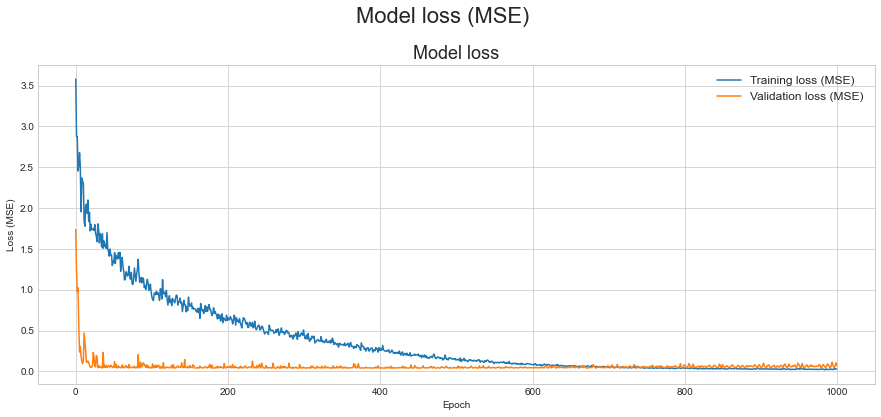

In [1160]:
from model import TransformerPos
## Best parameters
# Volume, price
# epochs=200
# lr=0.0000001
# use_mask=False

# On smlall data mask works bad

epochs=1000
# lr=0.000001
lr=0.00001

print(len(feature_columns))
model = TransformerPos(len(feature_columns), seq_len = train_len, dropout=0.2, use_mask=True)
train_losses, valid_losses = train_model(model, train_loader, valid_loader, epochs, lr)
# plot_losses(train_losses[20:], valid_losses[20:])
plot_losses(train_losses, valid_losses)

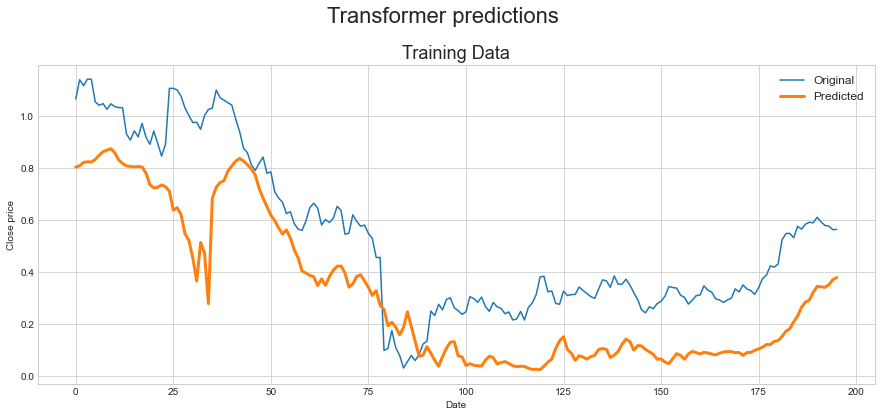

In [1163]:
original, predictions = predict(model, [valid_loader, test_loader])
draw_prediction(original, predictions)

## Transformer Time2Vector

In [51]:
# Data columns
print(data.columns)
# target_column = "Adj Close"
# feature_columns = ["Adj Close"]

target_column = "Adj Close"
feature_columns = ["Adj Close", "Volume"]

# target_column = "Return"
# feature_columns = ["Return", "Volume"]

# target_column = "Return Norm"
# feature_columns = ["Return Norm", "Volume"]

# target_column = "Adj Close"
# feature_columns = ["Adj Close", "Volume Norm"]

# target_column = "Return Norm"
# feature_columns = ["Return Norm", "Volume Norm"]

# target_column = "Adj Close"
# feature_columns = ["Adj Close", "Volume", "Return"]

# target_column = "Adj Close"
# feature_columns = ["Adj Close", "Volume", "VWAP", "SRSI"]

# Scalers
scalers = [
    (["Adj Close"], MinMaxScaler()),
    (["Volume"], MinMaxScaler()),
    # (["VWAP"], MinMaxScaler()),
    # (["SRSI"], MinMaxScaler()),
    # (["Return"], MinMaxScaler()),
    # (["Return Norm"], None),
]

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'EWM_0.1',
       'EWM_0.3', 'EWM_0.5', 'EWM_0.9', 'EWM', 'VWAP', 'ROC', 'RSI', 'SRSI',
       'Return', 'Return Log', 'Return Norm'],
      dtype='object')


In [52]:
# Create loaders
train_loader, valid_loader, test_loader = create_loaders(data[feature_columns], target_column, scalers, valid_len, test_len)

Train data shape: (522, 2)
Valid data shape: (105, 2)
Test data shape: (105, 2)
Transform columns ['Adj Close']
Transform columns ['Volume']
Transform columns ['Adj Close']
Transform columns ['Volume']
Transform columns ['Adj Close']
Transform columns ['Volume']


Epoch 1
Train loss: 4.246429


/Users/nin/opt/anaconda3/envs/udacity/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/nin/opt/anaconda3/envs/udacity/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test loss: 1.657575
Epoch 2
Train loss: 3.513477
Test loss: 1.899811
Epoch 3
Train loss: 2.582512
Test loss: 3.497858
Epoch 4
Train loss: 2.590702
Test loss: 1.747998
Epoch 5
Train loss: 2.337156
Test loss: 1.060300
Epoch 6
Train loss: 2.380458
Test loss: 1.154464
Epoch 7
Train loss: 2.721007
Test loss: 0.753876
Epoch 8
Train loss: 2.464968
Test loss: 0.574831
Epoch 9
Train loss: 2.678984
Test loss: 0.819582
Epoch 10
Train loss: 2.440015
Test loss: 1.622615
Epoch 11
Train loss: 2.122747
Test loss: 1.259150
Epoch 12
Train loss: 2.034031
Test loss: 1.060921
Epoch 13
Train loss: 2.080620
Test loss: 0.714185
Epoch 14
Train loss: 1.841780
Test loss: 1.139838
Epoch 15
Train loss: 1.706445
Test loss: 0.902359
Epoch 16
Train loss: 1.895765
Test loss: 1.238591
Epoch 17
Train loss: 1.976555
Test loss: 0.789990
Epoch 18
Train loss: 1.709931
Test loss: 0.356295
Epoch 19
Train loss: 2.056753
Test loss: 0.667003
Epoch 20
Train loss: 1.814261
Test loss: 0.239365
Epoch 21
Train loss: 2.100115
Test los

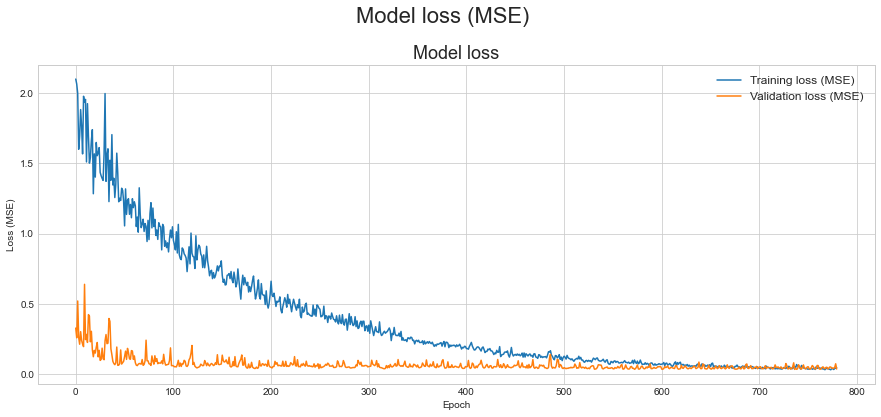

In [53]:
from model import TransformerTime2Vec
# lr=0.0000001 - best
# lr=0.000001 - 0.000005 - best for generated data
# On small data has poor performance
epochs=800
lr=0.00001

# TODO synchronize positional and time2vec encodding between samples.
model = TransformerTime2Vec(feature_size=len(feature_columns), use_mask=True)
train_losses, valid_losses = train_model(model, train_loader, valid_loader, epochs, lr)
plot_losses(train_losses[20:], valid_losses[20:])

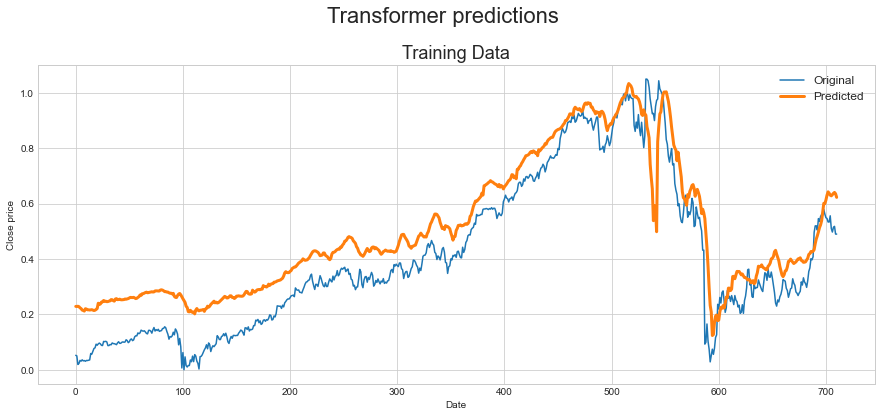

In [55]:
original, predictions = predict(model, [train_loader, valid_loader, test_loader])
draw_prediction(original, predictions)